# Introdução às Redes Neurais Convolucionais em Grafos para Séries Temporais

As **Redes Neurais Convolucionais em Grafos** (Graph Convolutional Networks, ou GCNs) têm se mostrado uma ferramenta poderosa para capturar padrões complexos em dados estruturados em forma de grafos, como redes de transporte, redes sociais e interações moleculares. No entanto, muitos problemas no mundo real também envolvem uma dimensão temporal, onde as relações entre as entidades mudam com o tempo. Isso exige a criação de modelos capazes de capturar **dependências espaciais** e **temporais** simultaneamente.

A combinação dessas duas dimensões resulta em uma nova classe de problemas conhecidos como **Redes Neurais Espaciais-Temporais em Grafos** (Spatio-Temporal Graph Neural Networks, ou ST-GNNs). Esses modelos são aplicados em uma variedade de tarefas, como previsão de tráfego, análise de redes de sensores e modelagem de interações dinâmicas em redes sociais.

Nesta apresentação, exploraremos como a GCN pode ser expandida para lidar com séries temporais, capturando tanto a estrutura do grafo quanto as mudanças ao longo do tempo. Vamos focar em exemplos práticos, como a **previsão de tráfego**, onde o tráfego entre diferentes segmentos de estrada é modelado como um grafo cujas características variam ao longo do tempo.

## Definição

Dado um grafo dinâmico $G(t) = (V, E, X_V(t), X_E(t))$, onde:

- $V$ é o conjunto de nós (vértices),
- $E$ é o conjunto de arestas (conexões entre os nós),
- $X_V(t) \in \mathbb{R}^{|V| \times d_V}$ representa as características dos nós (vértices) no tempo $t$, sendo $d_V$ a dimensionalidade das características dos nós,
- $X_E(t) \in \mathbb{R}^{|E| \times d_E}$ representa as características das arestas no tempo $t$, sendo $d_E$ a dimensionalidade das características das arestas.

![example](st_gnn.png)

# Motivação: Previsão de Trafégo

Neste exemplo, mostramos como prever as condições de tráfego utilizando redes neurais baseadas em grafos **(GNNs)** combinadas com **LSTM**. O foco é prever os valores futuros da velocidade do tráfego com base em um histórico de dados de uma coleção de segmentos de estrada.

Uma solução tradicional para este tipo de problema é tratar a velocidade de tráfego de cada segmento de estrada como uma série temporal individual, prevendo os valores futuros com base nos dados passados do próprio segmento. Entretanto, essa abordagem não considera as influências que os segmentos vizinhos exercem entre si.

Para capturar as interações complexas entre os diferentes segmentos de estrada, podemos modelar a rede de tráfego como um grafo, onde a velocidade do tráfego é representada como um sinal associado a esse grafo. Nesta abordagem, implementamos uma arquitetura de rede neural capaz de processar séries temporais sobre um grafo. Primeiramente, mostramos como preparar os dados e criar um `tf.data.Dataset` para previsão com grafos. Em seguida, desenvolvemos um modelo que combina camadas de convolução em grafos com LSTM para realizar a previsão.

## Carregando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import networkx as nx

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-10-06 20:30:09.174181: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 20:30:09.192915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 20:30:09.214815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 20:30:09.220904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 20:30:09.239075: I tensorflow/core/platform/cpu_feature_guar

## Dados

Utilizamos um conjunto de dados reais de velocidade de tráfego chamado **PeMSD7**. A versão do dataset está no repositório na pasta `data`.

O conjunto de dados **PeMSD7** abrange o **Distrito 7 da Califórnia** e consiste nas velocidades de tráfego registradas por **228 sensores** durante o período de maio a junho de 2012, apenas nos dias úteis, com um intervalo de coleta de **5 minutos**.

O conjunto de dados é composto por dois arquivos principais:

- **PeMSD7_W_228.csv**: Contém as distâncias entre as 228 estações localizadas no Distrito 7 da Califórnia.
- **PeMSD7_V_228.csv**: Contém as velocidades de tráfego coletadas nessas estações durante os dias úteis dos meses de maio e junho de 2012, com um intervalo de 5 minutos entre as medições.

Uma descrição completa do conjunto de dados pode ser encontrada no artigo de Yu et al. (2018).


![](PeMSD7-datasets.png)

In [2]:
# Lendo os arquivos CSV usando numpy
route_distances = np.loadtxt("../../data/pemsd7/PeMSD7_W_228.csv", delimiter=",")
speeds_array = np.loadtxt("../../data/pemsd7/PeMSD7_V_228.csv", delimiter=",")

### Grafo

In [3]:
route_distances

array([[    0.  ,  3165.94,  8731.54, ..., 22614.08, 26339.9 , 10012.42],
       [ 3165.94,     0.  ,  5625.76, ..., 21118.47, 24716.98,  9915.24],
       [ 8731.54,  5625.76,     0.  , ..., 20827.51, 23992.78, 13057.44],
       ...,
       [22614.08, 21118.47, 20827.51, ...,     0.  ,  3825.01, 13725.79],
       [26339.9 , 24716.98, 23992.78, ...,  3825.01,     0.  , 17550.36],
       [10012.42,  9915.24, 13057.44, ..., 13725.79, 17550.36,     0.  ]])

In [4]:
route_distances.shape

(228, 228)

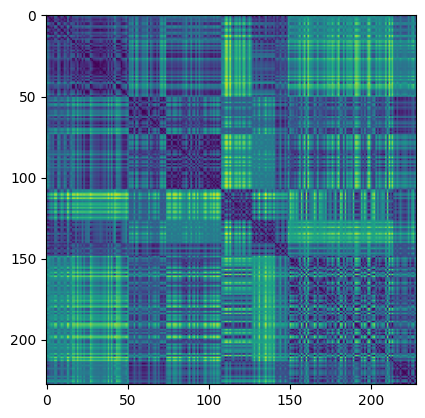

In [5]:
plt.imshow(route_distances)

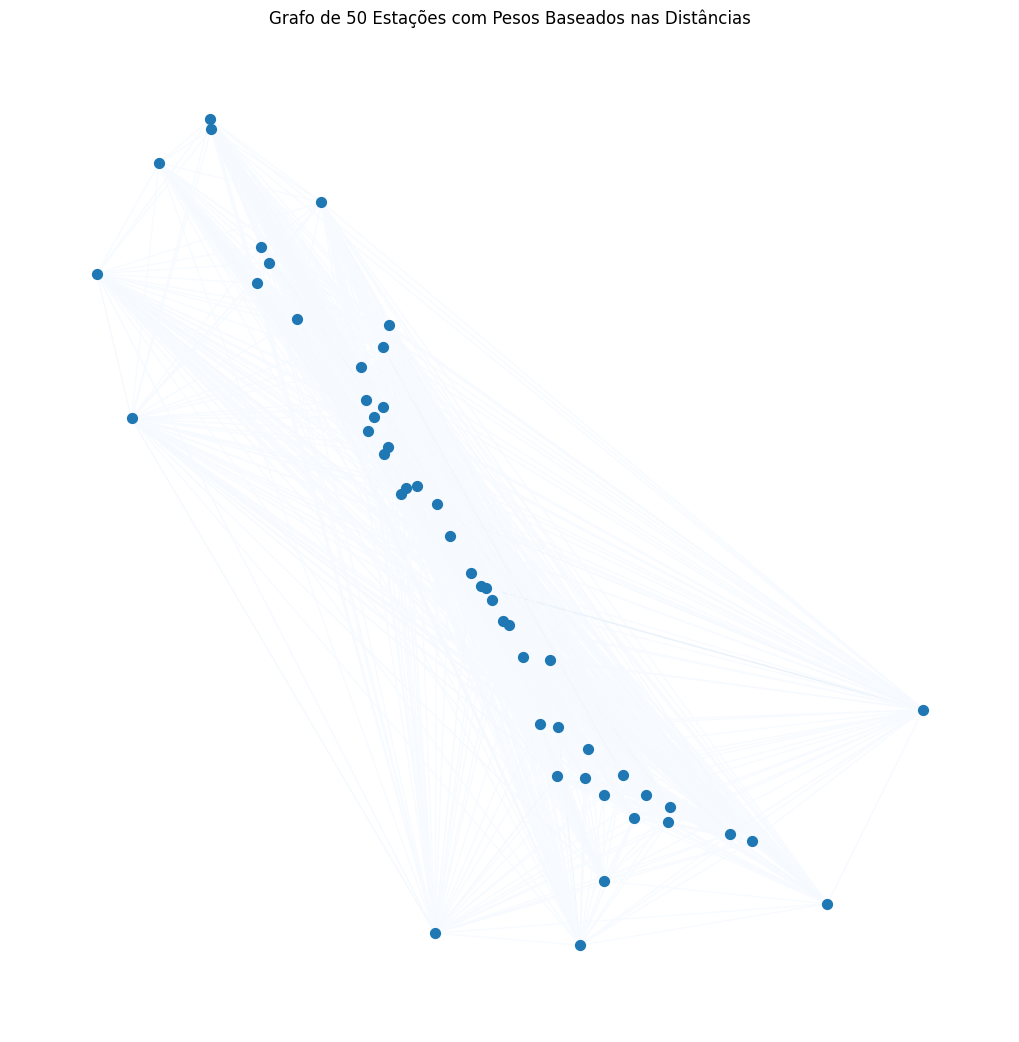

In [6]:
# Função para subamostrar as estações
def subamostrar_estacoes(route_distances, num_estacoes):
    indices = np.random.choice(route_distances.shape[0], num_estacoes, replace=False)
    sub_route_distances = route_distances[np.ix_(indices, indices)]
    return sub_route_distances, indices

num_estacoes = 50  # Altere para o número desejado de estações

# Subamostrando as estações
sub_route_distances, estacoes_indices = subamostrar_estacoes(route_distances, num_estacoes)

# Criando o grafo diretamente da matriz de adjacência (distâncias subamostradas)
G = nx.from_numpy_array(sub_route_distances)

# Plotando o grafo com as arestas ponderadas pelas distâncias
pos = nx.spring_layout(G, seed=42)  # Layout do grafo
edges = G.edges(data=True)
weights = [1 / (w['weight'] + 1) for _, _, w in edges]  # Pesos das arestas

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=50, edge_color=weights, edge_cmap=plt.cm.Blues)

plt.title(f"Grafo de {num_estacoes} Estações com Pesos Baseados nas Distâncias")
plt.show()

In [7]:
list(edges)

[(0, 1, {'weight': 11968.14}),
 (0, 2, {'weight': 15193.94}),
 (0, 3, {'weight': 34090.43}),
 (0, 4, {'weight': 28368.25}),
 (0, 5, {'weight': 772.65}),
 (0, 6, {'weight': 4252.73}),
 (0, 7, {'weight': 28443.61}),
 (0, 8, {'weight': 7551.27}),
 (0, 9, {'weight': 15679.09}),
 (0, 10, {'weight': 7975.3}),
 (0, 11, {'weight': 4785.77}),
 (0, 12, {'weight': 13418.24}),
 (0, 13, {'weight': 15927.97}),
 (0, 14, {'weight': 10760.58}),
 (0, 15, {'weight': 25648.67}),
 (0, 16, {'weight': 8544.52}),
 (0, 17, {'weight': 5661.09}),
 (0, 18, {'weight': 26864.27}),
 (0, 19, {'weight': 23079.69}),
 (0, 20, {'weight': 4023.96}),
 (0, 21, {'weight': 16852.24}),
 (0, 22, {'weight': 4735.39}),
 (0, 23, {'weight': 4252.73}),
 (0, 24, {'weight': 11188.26}),
 (0, 25, {'weight': 5044.36}),
 (0, 26, {'weight': 8988.26}),
 (0, 27, {'weight': 5324.85}),
 (0, 28, {'weight': 11950.69}),
 (0, 29, {'weight': 18721.44}),
 (0, 30, {'weight': 10189.58}),
 (0, 31, {'weight': 21152.74}),
 (0, 32, {'weight': 5547.86}),
 

### Série Temporal

In [8]:
speeds_array

array([[71.1, 66. , 64.6, ..., 69.3, 67.7, 68.9],
       [68.1, 66.8, 61.7, ..., 67.7, 68.8, 68.8],
       [68. , 64.3, 66.6, ..., 70.2, 69.1, 68.7],
       ...,
       [68.9, 37.9, 68.8, ..., 68.7, 67.5, 19.7],
       [69.2, 37.8, 68.7, ..., 67.7, 67.4, 19.5],
       [68.6, 52.9, 68.6, ..., 68.1, 68.5, 19.1]])

In [9]:
speeds_array.shape

(12672, 228)

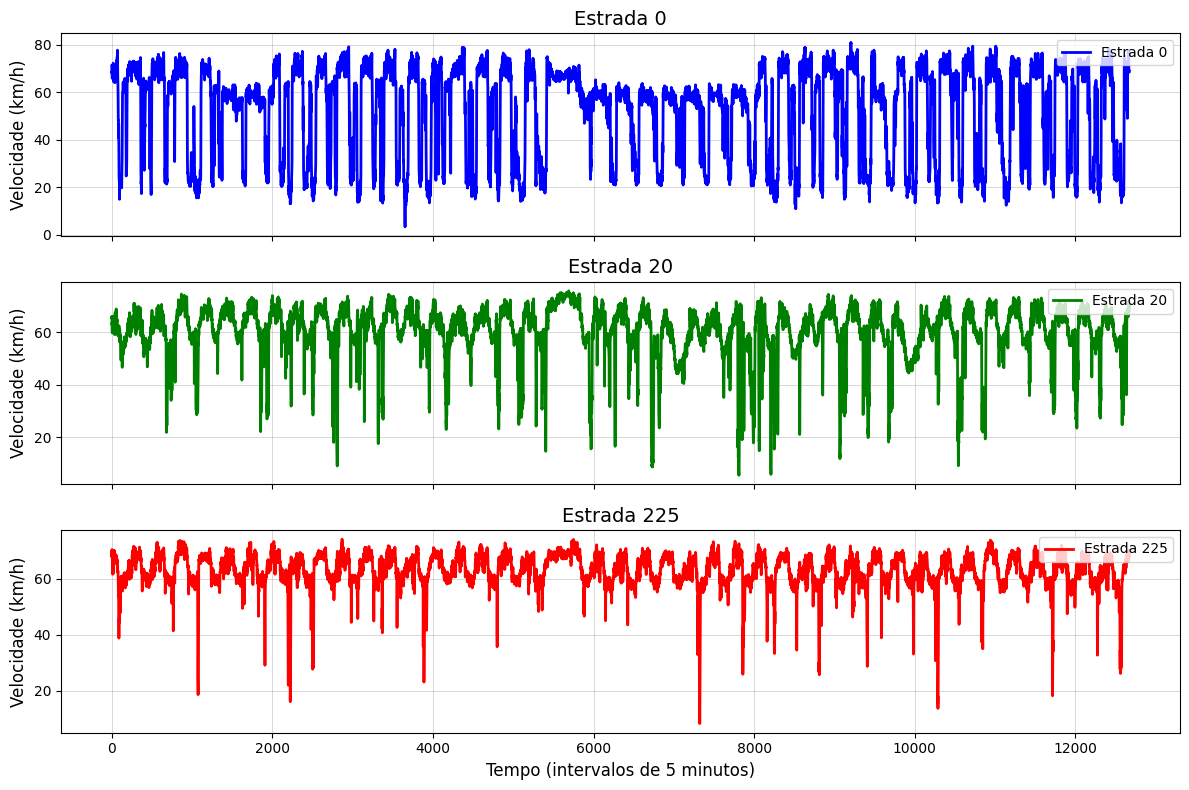

In [10]:
# Selecionar algumas estradas para plotar
selected_routes = [0, 20, 225]

# Criar subplots para as séries temporais das velocidades para as estradas selecionadas
fig, axs = plt.subplots(len(selected_routes), 1, figsize=(12, 8), sharex=True)

# Definir um conjunto de cores e estilos de linha para melhorar a visualização
colors = ['b', 'g', 'r']

for i, route in enumerate(selected_routes):
    axs[i].plot(speeds_array[:, route], color=colors[i], linewidth=2, label=f'Estrada {route}')
    axs[i].set_title(f"Estrada {route}", fontsize=14)
    axs[i].set_ylabel("Velocidade (km/h)", fontsize=12)
    axs[i].grid(True, which='both', linewidth=0.5, alpha=0.7)
    axs[i].legend(loc='upper right', fontsize=10)

# Definir rótulo do eixo x apenas para o último subplot
axs[-1].set_xlabel("Tempo (intervalos de 5 minutos)", fontsize=12)

# Melhorar layout dos subplots
plt.tight_layout()
plt.show()

## Subamostragem de Estradas

Para reduzir o tamanho do problema e tornar o treinamento mais rápido, trabalharemos com uma amostra de 26 estradas das 228 disponíveis no conjunto de dados. As estradas foram escolhidas começando pela estrada 0, selecionando as 5 estradas mais próximas a ela, e repetindo esse processo até obtermos 25 estradas. 

Você pode optar por qualquer outro subconjunto de estradas. Escolhemos as estradas dessa forma para aumentar a probabilidade de selecionar estradas cujas séries temporais de velocidade estejam correlacionadas.

`sample_routes` contém os IDs das estradas selecionadas.


In [12]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]

# # Definindo o número total de rotas no dataset e o número de rotas que queremos selecionar
# num_total_routes = 228  # Número total de rotas no dataset
# num_sample_routes = 50   # Número de rotas que queremos subamostrar

# Gerando uma amostra aleatória de 'num_sample_routes' rotas a partir do total de rotas
# sample_routes = np.random.choice(num_total_routes, num_sample_routes, replace=False)


route_distances = route_distances[np.ix_(sample_routes, sample_routes)] 
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


In [13]:
route_distances.shape

(26, 26)

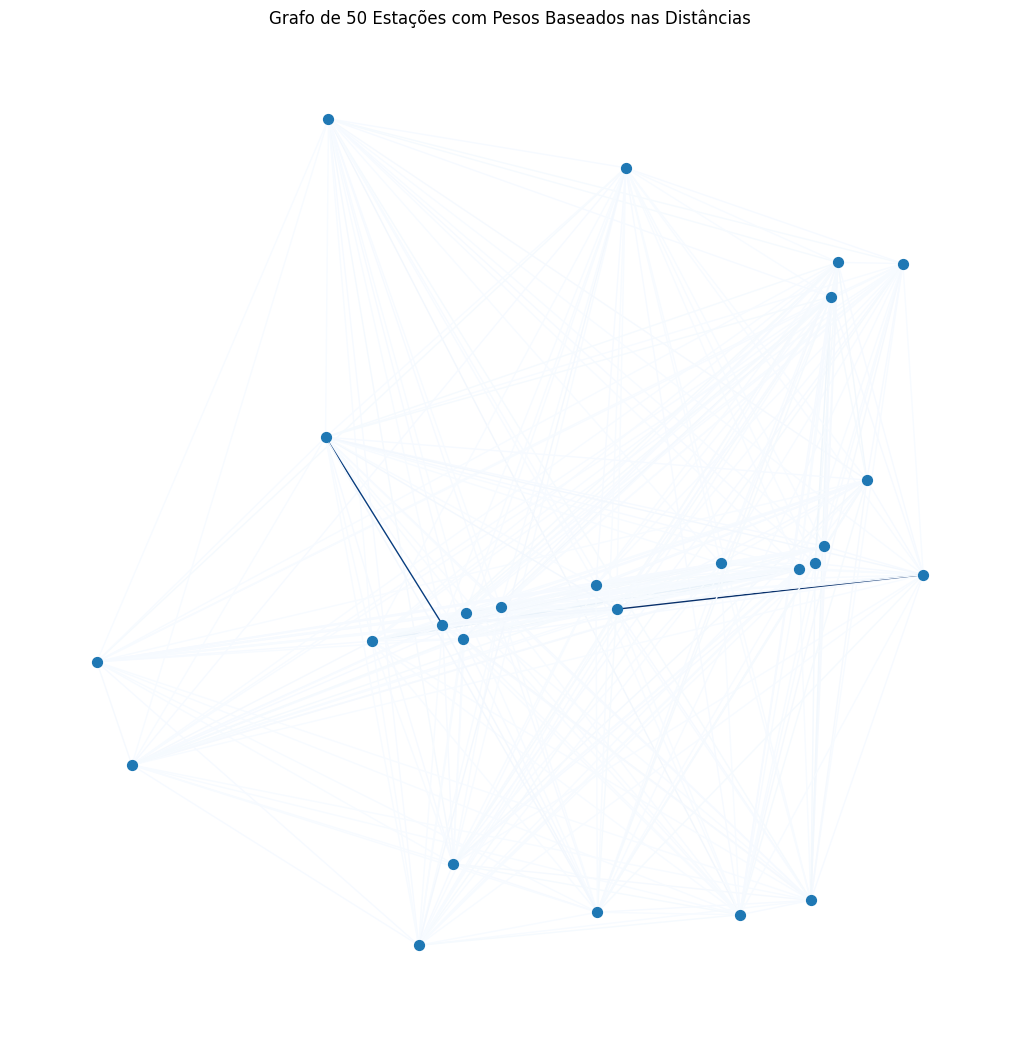

In [14]:
# Criando o grafo diretamente da matriz de adjacência (distâncias subamostradas)
G = nx.from_numpy_array(route_distances)

# Plotando o grafo com as arestas ponderadas pelas distâncias
pos = nx.spring_layout(G, seed=42)  # Layout do grafo
edges = G.edges(data=True)
weights = [1 / (w['weight'] + 1) for _, _, w in edges]  # Pesos das arestas

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=50, edge_color=weights, edge_cmap=plt.cm.Blues)

plt.title(f"Grafo de {num_estacoes} Estações com Pesos Baseados nas Distâncias")
plt.show()

<Figure size 1500x1500 with 0 Axes>

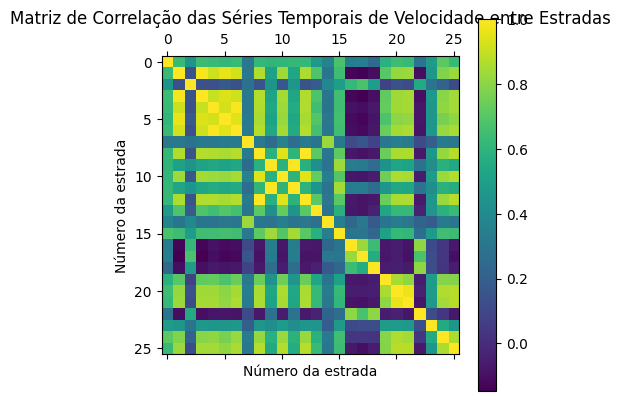

In [15]:
# Criar o gráfico de matriz de correlação com legenda
plt.figure(figsize=(15, 15))
corr_matrix = np.corrcoef(speeds_array.T)

# Plot da matriz de correlação
cax = plt.matshow(corr_matrix)

# Adicionar barra de cores (legenda)
plt.colorbar(cax)

# Definir rótulos para os eixos
plt.xlabel("Número da estrada")
plt.ylabel("Número da estrada")

plt.title("Matriz de Correlação das Séries Temporais de Velocidade entre Estradas")
plt.show()


## Spliting: Treino, validação e teste

In [16]:
train_size, val_size = 0.6, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (7603, 26)
validation set size: (2534, 26)
test set size: (2535, 26)


## Criação de Datasets no TensorFlow

Usamos a função `timeseries_dataset_from_array()` da Keras para criar os datasets para o nosso problema de previsão de tráfego. A função `create_tf_dataset()` recebe como entrada um `numpy.ndarray` e retorna um `tf.data.Dataset`. Nessa função, o argumento `input_sequence_length` é definido como **12**, representando o comprimento da sequência de entrada, e o argumento `forecast_horizon` é definido como **3**, representando o horizonte de previsão.

### multi_horizon

O argumento `multi_horizon` determina como os alvos (targets) serão gerados:
- Se `multi_horizon=True`, o modelo fará uma previsão para os passos de tempo t+T+1, t+T+2 e t+T+3. Portanto, o alvo terá a forma `(batch_size, forecast_horizon, num_routes)`, onde `forecast_horizon` será igual a 3.
- Se `multi_horizon=False`, o modelo fará a previsão apenas para o último passo de tempo t+T+3. Nesse caso, o alvo terá a forma `(batch_size, 1, num_routes)`.

## Nossos parâmetros

No nosso exemplo, usamos os seguintes parâmetros:
- `input_sequence_length = 12`: Usamos os últimos 12 valores de velocidade de cada estrada como entrada.
- `forecast_horizon = 3`: Prevemos a velocidade para os 3 próximos passos de tempo.
- `batch_size = 64`: Cada lote de dados terá 64 amostras.
- `multi_horizon = False`: Fazemos a previsão apenas para o último passo de tempo t+T+3.

A entrada do tensor em cada batch terá a forma `(batch_size, input_sequence_length, num_routes, 1)`, onde a última dimensão é 1, para representar uma única série temporal por estrada. Caso quiséssemos usar várias séries temporais (como temperatura ou outro dado), a última dimensão poderia ser maior. Neste exemplo, a previsão é feita somente com base nos valores históricos de velocidade.

A função `create_tf_dataset()` foi usada para criar os datasets de treino, validação e teste:

- `train_dataset` e `val_dataset` são criados a partir de `train_array` e `val_array`, respectivamente.
- `test_dataset` é criado a partir de `test_array`, com um `batch_size` igual ao número total de amostras de teste, sem embaralhamento (`shuffle=False`) e com `multi_horizon=True` ou `multi_horizon=False`, dependendo do objetivo da previsão.

In [29]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 12
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

## Séries de entrada e saída do modelo

Abaixo exibimos como são as séries que serão usadas como treino e teste para cada nó.

In [30]:
for batch_inputs, batch_targets in train_dataset.take(1): ## take(i) retorna o batch i
    batch_inputs = batch_inputs.numpy()
    batch_targets = batch_targets.numpy()

2024-10-06 20:31:27.996502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [31]:
batch_inputs.shape

(64, 12, 26, 1)

In [32]:
batch_targets.shape

(64, 12, 26)

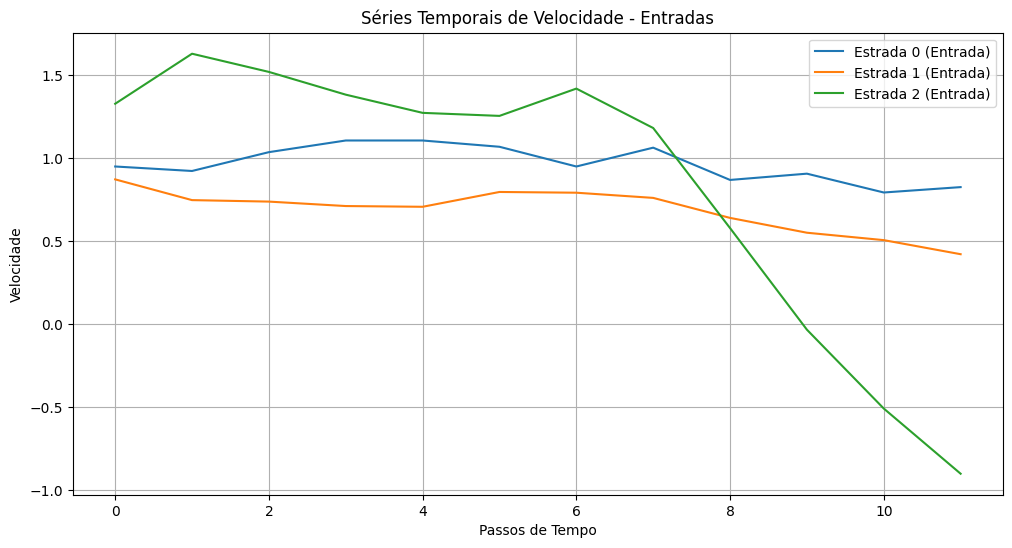

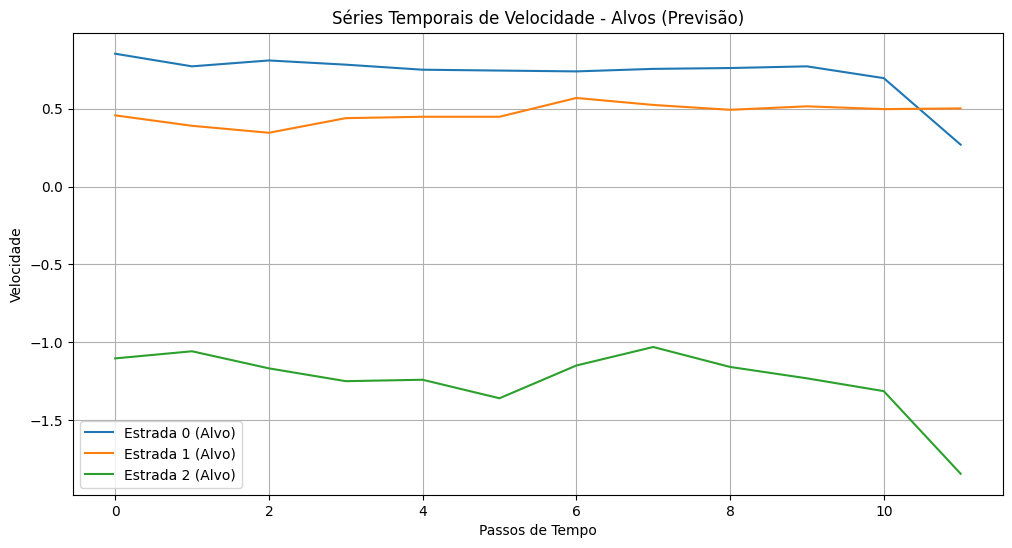

In [33]:
# Selecionar algumas estradas e exibir suas séries temporais
selected_routes = [0, 1, 2]  # Escolhendo três rotas como exemplo

plt.figure(figsize=(12, 6))
for route in selected_routes:
    plt.plot(batch_inputs[0, :, route, 0], label=f'Estrada {route} (Entrada)')

plt.title("Séries Temporais de Velocidade - Entradas")
plt.xlabel("Passos de Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

# Plotar as previsões (targets)
plt.figure(figsize=(12, 6))
for route in selected_routes:
    plt.plot(batch_targets[0, :, route], label=f'Estrada {route} (Alvo)')

plt.title("Séries Temporais de Velocidade - Alvos (Previsão)")
plt.xlabel("Passos de Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

## Grafo das Estradas

Como mencionado anteriormente, assumimos que os segmentos de estrada formam um grafo. O conjunto de dados **PeMSD7** contém as distâncias entre os segmentos de estrada. O próximo passo é criar a **matriz de adjacência** do grafo a partir dessas distâncias.

Assumimos que existe uma **aresta** entre dois nós no grafo se a distância entre as respectivas estradas for menor que um determinado **limite** (threshold).


In [34]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

### Explicação de `compute_adjacency_matrix`

A função `compute_adjacency_matrix` calcula a **matriz de adjacência** a partir de uma matriz de distâncias entre estradas, aplicando uma fórmula baseada no trabalho de Yu et al., 2018. Ela utiliza um **kernel Gaussiano** para determinar se há uma conexão (aresta) entre dois nós (estradas) no grafo.

### Argumentos:
1. **`route_distances`**: Um array NumPy com forma `(num_routes, num_routes)` que contém as distâncias entre as estradas. Cada entrada `i,j` representa a distância entre a estrada `i` e a estrada `j`.
2. **`sigma2`**: Um parâmetro que controla a largura do **kernel Gaussiano** aplicado às distâncias quadradas. Esse parâmetro influencia como a distância afeta a criação de arestas.
3. **`epsilon`**: Um **limite** que determina se uma aresta será criada entre dois nós. Especificamente, se a função Gaussiana aplicada às distâncias for maior ou igual a `epsilon`, uma aresta será criada.

### Passo a Passo:

1. **`num_routes = route_distances.shape[0]`**: 
   - Calcula o número de estradas a partir da dimensão da matriz de distâncias.

2. **`route_distances = route_distances / 10000.0`**: 
   - Normaliza os valores da matriz de distâncias, dividindo cada valor por 10.000. Isso ajuda a evitar problemas numéricos durante o cálculo exponencial.

3. **`w2 = route_distances * route_distances`**:
   - Calcula a matriz de distâncias ao quadrado. O valor para cada estrada `i` e `j` é o quadrado da distância entre elas: `w2[i,j] = route_distances[i,j]^2`.

4. **`w_mask = np.ones([num_routes, num_routes]) - np.identity(num_routes)`**:
   - Cria uma **máscara** para remover as auto-conexões. Essa matriz contém `1`s em todas as posições exceto na diagonal principal (que são `0`s), pois não queremos criar arestas entre um nó e ele mesmo.

5. **`np.exp(-w2 / sigma2)`**:
   - Aplica a função Gaussiana às distâncias quadradas. A fórmula usada é:
     $$
     \exp\left(-\frac{w2[i,j]}{\sigma2}\right)
     $$
     Essa função decai exponencialmente com a distância: distâncias pequenas produzem valores próximos de 1 (alta conexão), e distâncias grandes resultam em valores próximos de 0.

6. **`(np.exp(-w2 / sigma2) >= epsilon)`**:
   - Verifica se o valor da função Gaussiana é maior ou igual ao limite `epsilon`. Se for, uma aresta é criada entre os nós (estradas) `i` e `j`.

7. **`* w_mask`**:
   - Multiplica pela máscara para garantir que não existam arestas que conectem uma estrada a ela mesma. As auto-conexões são removidas definindo a diagonal como `0`.

### Retorno:
- A função retorna uma **matriz booleana de adjacência**, onde:
  - `True`: Há uma aresta entre as estradas (nós),
  - `False`: Não há uma aresta entre as estradas.

In [35]:
# Nosso gráfo é estático!!! logo só precisamos calcular uma vez

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")



number of nodes: 26, number of edges: 150


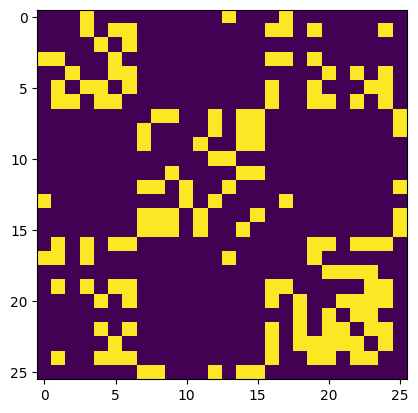

In [36]:
plt.imshow(adjacency_matrix)

## Convoluções em Grafos como Message Passing

Cada camada de convolução em grafos processa os **vetores de características** dos nós provenientes da camada anterior (ou, no caso da primeira camada, os vetores de entrada), gerando novos vetores de saída para cada nó. O princípio fundamental por trás da convolução em grafos é o **Message Passing**, onde cada nó atualiza seu vetor de características ao "agregar" informações dos seus nós vizinhos.

### Como funciona

O processo de convolução pode ser visto como um mecanismo de **propagação de mensagens** entre os nós, onde a informação flui de nó para nó, permitindo que a rede aprenda padrões tanto estruturais quanto de características nos dados.

A imagem abaixo ilustra esse processo de "passagem de mensagem" em uma camada de convolução em grafos:

![message](GCN_conv_layer_message_pass_1.png)


No esquema acima, o vetor do nó A, denotado por $x_A$, é agregado aos vetores de seus vizinhos, $x_B$ e $x_C$. Esse vetor agregado é então transformado/atualizado para formar o novo vetor do nó A na próxima camada, denotado por $h_A$. Esse procedimento é aplicado a cada nó do grafo.

Esse processo pode ser descrito em duas etapas:

1. **Agregação**: O nó A coleta as informações de seus vizinhos (nós B e C), criando um vetor agregado.
2. **Transformação**: O vetor agregado é transformado através de uma função (linear ou não-linear), resultando no novo vetor do nó A, $h_A$.


## Como isso se relaciona com a última aula?

O procedimento de convolução em grafos é frequentemente chamado de **message passing** (passagem de mensagens), pois cada nó "envia" seu vetor de características para seus vizinhos com o objetivo de atualizar os vetores desses nós. A "mensagem" de cada nó é representada pelo vetor associado a ele.

Agora, como exatamente uma GCN realiza a agregação e atualização? Para responder a isso, vamos analisar a matemática por trás da camada de convolução em grafos. Seja $X \in \mathbb{R}^{n \times d}$ as características associadas aos nós, onde $n$ é o número de nós e $d$ é o número de características. Ou seja, a linha $i$ de $X$ armazena as características do nó $i$. Seja $A$ a matriz de adjacência do grafo, onde:

$$
A_{i,j} = 
\begin{cases}
1, & \text{se houver uma aresta entre os nós } i \text{ e } j \\
0, & \text{caso contrário}
\end{cases}
$$

**Como vimos na outra aula**, as matrizes $X$ e $A$ são as duas peças de dados necessárias como entrada para uma GCN aplicada a um grafo. A camada de convolução em grafos pode ser expressa como uma função que aceita essas duas entradas e retorna uma matriz que representa os vetores atualizados de cada nó. Esta função é dada por:

$$
f(X, A) := \sigma(D^{-1/2}(A + I)D^{-1/2}XW)
$$

Onde:
- $A \in \mathbb{R}^{n \times n}$: Matriz de adjacência.
- $I \in \mathbb{R}^{n \times n}$: Matriz identidade.
- $D \in \mathbb{R}^{n \times n}$: Matriz de grau de $A + I$.
- $X \in \mathbb{R}^{n \times d}$: Matriz de entrada (os vetores de características dos nós).
- $W \in \mathbb{R}^{d \times w}$: Pesos da camada.
- $\sigma(\cdot)$: Função de ativação (ex: ReLU).


![equation](GCN_layer_equation_annotated.png)

### Entendendo cada multiplicação de matrizes:

1. **A + I**: Esta operação adiciona 1s à diagonal da matriz de adjacência. Isso é equivalente a adicionar self-loops (auto-conexões) ao grafo, garantindo que cada nó também passe sua própria mensagem para si mesmo durante o processo de agregação.

2. **D**: A matriz de grau de $A + I$. É uma matriz diagonal onde o elemento $d_{i,i}$ armazena o número total de nós vizinhos do nó $i$ (incluindo ele mesmo, após a adição dos self-loops).

3. **D^{-1/2}**: O inverso da raiz quadrada da matriz de grau. Esta matriz é usada para normalizar a matriz de adjacência. A multiplicação $D^{-1/2}(A + I)D^{-1/2}$ normaliza o grafo, garantindo que os valores nas arestas sejam ajustados proporcionalmente ao grau dos nós.

4. **Ã**: Após a normalização, denotamos a nova matriz como $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$. Isso assegura que $\tilde{A}_{i,j} \neq 0$ apenas se houver uma aresta entre os nós $i$ e $j$.

Agora podemos simplificar a função da camada de convolução em grafos **(como na última aula)**:

$$
f(X, A) := \sigma(\tilde{A} X W)
$$

### Agregação e Passagem de Mensagens

A multiplicação $\tilde{A} X$ realiza a função de agregação ou **message passing**. Para cada nó $i$, os vetores das características dos nós vizinhos são combinados (somados) com pesos determinados pela matriz normalizada $\tilde{A}$.

![aggreg](GCN_aggregation_matrices.png)


Seja $\bar{x}_i$ o vetor agregado no nó $i$. Ele pode ser expresso como:

$$
\bar{x}_i = \sum_{j=1}^{n} \tilde{a}_{i,j} x_j = \sum_{j \in Neigh(i)} \frac{1}{\sqrt{d_i d_j}} x_j
$$

Aqui, o vetor no nó $i$ é uma soma ponderada dos vetores dos nós vizinhos, com os pesos armazenados na matriz $\tilde{A}$. Esses pesos não são aprendidos, mas determinados exclusivamente com base na estrutura do grafo.

### Atualização com Pesos Aprendidos

Os pesos aprendidos, que são os parâmetros do modelo, estão armazenados na matriz $W$. A multiplicação $(\tilde{A} X) W$ aplica esses pesos aos vetores agregados para atualizar as características de cada nó.

Finalmente, esses vetores atualizados são passados por uma função de ativação $\sigma$, que introduz não-linearidade no modelo.

![update](GCN_update_matrices.png)

### Múltiplas Camadas de Convolução em Grafos

Até agora, discutimos uma única camada de convolução em grafos. No entanto, podemos empilhar várias camadas de convolução. A saída de uma camada serve como entrada para a próxima. Matematicamente, podemos expressar isso da seguinte forma:

$$
H_1 := f_{W_1}(X, A), \quad H_2 := f_{W_2}(H_1, A), \quad H_3 := f_{W_3}(H_2, A)
$$

Onde $H_1$, $H_2$, e $H_3$ são os vetores incorporados dos nós nas camadas 1, 2 e 3, respectivamente. As matrizes $W_1$, $W_2$, e $W_3$ são as matrizes de pesos que parametrizam cada camada.


### Agregação Personalizada

Embora a agregação na camada de convolução em grafos, conforme descrita anteriormente, seja frequentemente realizada como uma **soma ponderada** dos vetores dos nós vizinhos, essa não é a única forma de agregação. Existem diversas estratégias de agregação que podem ser usadas, dependendo da natureza do problema ou das características específicas do grafo.

#### Exemplos de Agregações Alternativas:

1. **Média**: Em vez de somar os vetores dos nós vizinhos, podemos calcular a **média**. Isso pode ser útil para suavizar as diferenças entre os vetores vizinhos, normalizando a contribuição de cada um.
   $$
   \bar{x}_i = \frac{1}{|Neigh(i)|} \sum_{j \in Neigh(i)} x_j
   $$

2. **Agregação Máxima**: Em alguns cenários, podemos usar a **agregação máxima**, onde tomamos o valor máximo entre os vetores dos vizinhos, aplicando uma espécie de filtro que seleciona as características mais "fortes" ou dominantes.
   $$
   \bar{x}_i = \max_{j \in Neigh(i)} x_j
   $$

3. **Concatenar**: Outra forma é **concatenar** os vetores dos vizinhos, em vez de somá-los ou tirar a média. Esse método preserva mais informações dos nós vizinhos, mas pode aumentar consideravelmente a dimensionalidade dos vetores.
   $$
   \bar{x}_i = \text{concat}(x_j \text{ para } j \in Neigh(i))
   $$

4. **Atendimento por Atenção (Attention)**: Em modelos mais avançados, como o **Graph Attention Network (GAT)**, a agregação pode ser feita usando um mecanismo de atenção, onde cada vizinho contribui com um peso aprendido dinâmicamente, permitindo que o modelo ajuste a importância de cada vizinho em tempo real.
   $$
   \bar{x}_i = \sum_{j \in Neigh(i)} \alpha_{ij} x_j
   $$
   Onde os pesos $\alpha_{ij}$ são calculados com base em um mecanismo de atenção.

Portanto, a operação de agregação pode ser flexível e adaptável às necessidades do modelo, permitindo diferentes formas de capturar a estrutura e as características dos nós e seus vizinhos.


## Voltando ao problema...

### Arquitetura da GNN

A arquitetura da rede fica como abaixo. As representações dos nós são calculadas na função `self.compute_nodes_representation()`, onde as características de entrada são multiplicadas pelos pesos armazenados em `self.weight`. 

As mensagens agregadas dos vizinhos são calculadas na função `self.compute_aggregated_messages()`, onde as representações dos vizinhos são primeiramente agregadas e, em seguida, os resultados são multiplicados por `self.weight`.

A saída final da camada é calculada na função `self.update()`, combinando as representações dos nós com as mensagens agregadas dos vizinhos.


In [37]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

### Arquitetura da LSTM+GC

In [38]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

### Entendendo a LSTM no Grafo

A camada **LSTMGC** combina convoluções em grafos com uma camada LSTM para capturar tanto as **dependências espaciais** (estrutura do grafo) quanto as **temporais** (evolução das características ao longo do tempo). Abaixo está o detalhamento de como cada parte do processo funciona:

1. **Convolução em Grafos (`GraphConv`)**:
   - A camada de convolução em grafos processa as entradas de cada nó, agregando informações dos nós vizinhos de acordo com a estrutura do grafo. Isso permite que as características dos nós sejam atualizadas com base nas interações espaciais com seus vizinhos. 
   - A saída da convolução tem a forma `(num_nodes, batch_size, input_seq_len, out_feat)`, onde:
     - **`num_nodes`**: O número de nós no grafo.
     - **`batch_size`**: O número de amostras processadas simultaneamente.
     - **`input_seq_len`**: O comprimento da sequência temporal de entrada.
     - **`out_feat`**: O número de características de saída por nó, atualizado pela convolução.

2. **Camada LSTM**:
   - A LSTM captura as **dependências temporais** de cada nó individualmente. Como a LSTM requer uma entrada tridimensional, o tensor de saída da convolução em grafos é reestruturado para ter a forma `(batch_size * num_nodes, input_seq_len, out_feat)`, combinando o número de nós e o tamanho do batch.
   - A LSTM processa as sequências temporais de características de cada nó, aprendendo como elas mudam ao longo do tempo, e gera uma saída de forma `(batch_size * num_nodes, lstm_units)`, onde **`lstm_units`** define o número de unidades internas da LSTM.

3. **Camada Densa**:
   - A saída da LSTM é então passada por uma camada densa que transforma esses vetores de características em previsões temporais. A camada densa ajusta a dimensionalidade para a forma `(batch_size * num_nodes, output_seq_len)`, onde **`output_seq_len`** representa o número de passos temporais previstos para cada nó.

4. **Reshape Final**:
   - O tensor é reestruturado novamente para a forma `(batch_size, output_seq_len, num_nodes)`, organizando as previsões temporais por nó, de forma que o modelo forneça uma previsão de sequência de tempo para cada nó no grafo.



## Treinando o modelo

In [39]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 12
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

In [40]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.9250 - val_loss: 0.6561
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.5564 - val_loss: 0.4372
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.3945 - val_loss: 0.3503
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.3360 - val_loss: 0.3216
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.3078 - val_loss: 0.3063
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2907 - val_loss: 0.2974
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2801 - val_loss: 0.2909
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2731 - val_loss: 0.2858
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.2686 - val_loss: 0.2818
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.2654 - val_loss: 0.2787
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.2631 - val_loss: 0.2762
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
naive MAE: 0.5570061163490823, model MAE: 0.5285183402152485


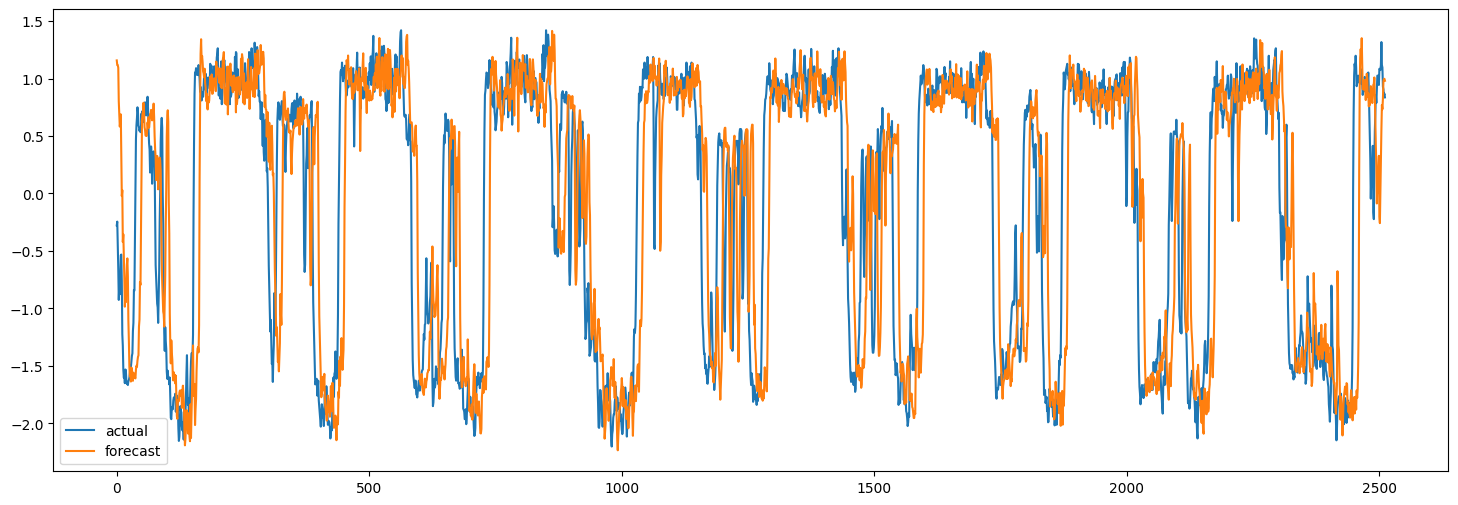

In [41]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")